In [ ]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning
!pip install --quiet tokenizers
!pip install --quiet timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.2/826.2 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 12.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import json
import os
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import timm
from torch import nn
import PIL
import torchvision.models as models

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from transformers import (AdamW,T5ForConditionalGeneration, AutoTokenizer as Tokenizer)

# **Pre-Process the Data**

In [ ]:
_URL = 'http://images.cocodataset.org/zips/val2014.zip'
zip_dir = tf.keras.utils.get_file('/content/MSCOCOVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/MSCOCOVAL2014.zip'
!unzip -q $fname -d /content/

6645013297/6645013297 [==============================] - 352s 0us/step


In [ ]:
_URL = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip'
zip_dir = tf.keras.utils.get_file('/content/QUESVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/QUESVAL2014.zip'
!unzip -q $fname -d /content/

3494929/3494929 [==============================] - 0s 0us/step


In [ ]:
_URL = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip'
zip_dir = tf.keras.utils.get_file('/content/ANNOTVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/ANNOTVAL2014.zip'
!unzip -q $fname -d /content/

10518930/10518930 [==============================] - 1s 0us/step


In [ ]:
valtxt = 'https://raw.githubusercontent.com/jponttuset/mcg/master/pre-trained/datasets/COCO/gt_sets/val2014.txt'
zip_dir = tf.keras.utils.get_file('/content/valtxt.txt', origin=valtxt, extract=False,archive_format='auto')

1053103/1053103 [==============================] - 0s 0us/step


In [ ]:
with open(os.path.join('/content/', 'v2_OpenEnded_mscoco_val2014_questions.json'), 'r') as f:
    val_questions = json.load(f)['questions']
with open(os.path.join('/content/', 'v2_mscoco_val2014_annotations.json'), 'r') as f:
    val_answers = json.load(f)['annotations']

In [ ]:
val_data = []
for question, annotation in zip(val_questions, val_answers):
    question_text = question['question']
    image_id = annotation['image_id']
    answer = annotation['answers'][0]['answer']
    image_filename = 'COCO_val2014_{:012d}.jpg'.format(image_id)
    image_path = os.path.join('/content/', 'val2014', image_filename)
    val_data.append({'question': question_text, 'image_path': image_path, 'answer': answer})

In [ ]:
# Convert the array of dictionaries to a DataFrame
df = pd.DataFrame(val_data)

In [ ]:
df

,question,image_path,answer
0,Where is he looking?,/content/val2014/COCO_val2014_000000262148.jpg,down
1,What are the people in the background doing?,/content/val2014/COCO_val2014_000000262148.jpg,spectating
2,What is he on top of?,/content/val2014/COCO_val2014_000000262148.jpg,table
3,What website copyrighted the picture?,/content/val2014/COCO_val2014_000000393225.jpg,foodiebakercom
4,Is this a creamy soup?,/content/val2014/COCO_val2014_000000393225.jpg,no
...,...,...,...
214349,What is the main color in the photo?,/content/val2014/COCO_val2014_000000393212.jpg,green
214350,What is the meaning of this sign?,/content/val2014/COCO_val2014_000000393212.jpg,one way
214351,What is on the sign?,/content/val2014/COCO_val2014_000000393212.jpg,arrow
214352,Does the arrow point left or right?,/content/val2014/COCO_val2014_000000393212.jpg,left


In [ ]:
def show_sample(idx=0):
  print("Q : ",df.iloc[idx]['question'])
  image = cv2.imread(df.iloc[idx]['image_path'])
  image = cv2.resize(image, (224, 224))  
  cv2_imshow(image)
  print("A : ",df.iloc[idx]['answer'])

Q :  Why is there a gap between the roof and wall?


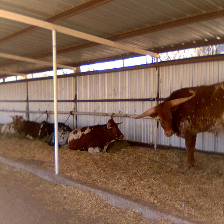

A :  ventilation


In [ ]:
show_sample(10)

# **DataLoader**

In [ ]:
def has_three_channels(image_path):
    with PIL.Image.open(image_path) as img:
        return img.mode == 'RGB'

# Filter the DataFrame to keep only the images with 3 channels
df = df[df['image_path'].apply(has_three_channels)]

In [ ]:
max_length = len(df['answer'].max())
print(max_length)

6


In [ ]:
max_length = len(df['question'].max())
print(max_length)

26


In [ ]:
MODEL_NAME = 't5-small'

In [ ]:
tokenizer = Tokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
train_df, val_df = train_test_split(df,test_size=0.1)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [ ]:
class VQADataset(Dataset):
    def __init__(self, df, transform,tokenizer):
        self.df = df
        self.transform = transform
        self.tokenizer = tokenizer
        self.img_model = timm.create_model('xception', pretrained=True)
        self.img_model.aux_logits=False
        self.img_model.train(False)


        # Freeze training for all layers
        for param in self.img_model.parameters():
            param.requires_grad = False
        
        self.img_model.fc = torch.nn.Sequential(torch.nn.Linear(self.img_model.fc.in_features, 256),
                          torch.nn.Dropout(0.5),
                          torch.nn.ReLU(inplace=True),
                          torch.nn.BatchNorm1d(256),
                          torch.nn.Linear(256, 64))
        
        self.img_model.eval()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        question = row['question']
        image_path = row['image_path']
        answer = row['answer']

        answer = self.tokenizer(answer, padding='max_length',truncation = True,return_attention_mask = True,add_special_tokens = True, max_length=64, return_tensors='pt')

        labels = answer["input_ids"]
        labels[labels == 0] = -100
        
        # load the image and apply transform
        img = PIL.Image.open(image_path)
        img = img.convert('RGB')

        img_array = np.array(img)
        if img_array.shape[0] == 1:
            img_array = np.repeat(img_array, 3, axis=0)

        # Convert the NumPy array back to a PIL image and apply the transforms
        img = PIL.Image.fromarray(img_array)
        
        img = transform(img)


        img = img.unsqueeze(0)

        # Generate the image embedding
        with torch.no_grad():
            features = self.img_model(img)

        img = img.squeeze()
        
        img = ','.join(str(x) for x in img)
        quesimg = f"question: {question} context: {img}"

        quesimg = self.tokenizer(quesimg, padding='max_length',truncation = True,return_attention_mask = True,add_special_tokens = True, max_length=140, return_tensors='pt')

        
        return dict(
        input_ids = quesimg['input_ids'].flatten(),
        attention_mask = quesimg['attention_mask'].flatten(),
        labels = labels.flatten())

In [ ]:
class VQADataModule(pl.LightningDataModule):
  def __init__(self,train_df : pd.DataFrame,test_df : pd.DataFrame,transform : transform,tokenizer : tokenizer,batch_size : int = 8):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.transform = transform


  def setup(self,stage=None):
    self.train_dataset = VQADataset(self.train_df,self.transform,self.tokenizer)
    self.test_dataset = VQADataset(self.test_df,self.transform,self.tokenizer)

  def train_dataloader(self):
    return DataLoader(self.train_dataset,batch_size = self.batch_size,shuffle=True,num_workers=4)

  def val_dataloader(self):
    return DataLoader(self.test_dataset,batch_size = self.batch_size,num_workers=4)

  def test_dataloader(self):
    return DataLoader(self.test_dataset,batch_size = self.batch_size,num_workers=4)

In [ ]:
BATCH_SIZE = 8
N_EPOCHS = 5

data_module = VQADataModule(train_df,val_df,transform,tokenizer,batch_size = BATCH_SIZE)
data_module.setup()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


# **Model Architecture**

In [ ]:
class VQAModel(pl.LightningModule):
  def __init__(self):
    super().__init__()

    self.text_model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME,return_dict=True)
    self.lossfn = nn.CrossEntropyLoss()
                  

  def forward(self,input_ids,attention_mask,labels=None):
    output = self.text_model(input_ids = input_ids,attention_mask = attention_mask,labels = labels)
    return output.loss, output.logits

  def training_step(self,batch,batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self(input_ids,attention_mask,labels)
    self.log("train_loss",loss,prog_bar=True,logger=True)
    return loss

  def validation_step(self,batch,batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self(input_ids,attention_mask,labels)
    self.log("val_loss",loss,prog_bar=True,logger=True)
    return loss

  def test_step(self,batch,batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self(input_ids,attention_mask,labels)
    self.log("test_loss",loss,prog_bar=True,logger=True)
    return loss

  def configure_optimizers(self):
    return AdamW(self.parameters(),lr = 0.0001)

# **Training**

In [ ]:
model = VQAModel()

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'best_cp',
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min')

In [ ]:
trainer = pl.Trainer(gpus=1,
    callbacks=[checkpoint_callback],
    max_epochs = 5)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model,data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type                       | Params
----------------------------------------------------------
0 | text_model | T5ForConditionalGeneration | 60.5 M
1 | lossfn     | CrossEntropyLoss           | 0     
----------------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]